In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint

%load_ext autoreload
%autoreload 2

import interface
import normalization
from neural_networks.fully_connected import FC
from neural_networks.h2mgnode import H2MGNODE

# Choose dataset

In [2]:
data_dir='data/data_json/case14'

# Defining a series of normalizing functions

The features contained in power systems objects may have very different orders of magnitude and display complex distributions with possibly multiple modes. For this reason, it is very important to build a series of functions that can convert those atypical distributions into something that looks more like a uniform law between $-1$ and $1$.

This normalization process is done by computing a piecewise linear approximation of the cumulative distribution function of each required feature. This estimation is performed by considering a subset of the trainset. This estimation does not need to be perfect, so it seems reasonable to estimate it over a reasonably small amount of samples (see option *amount_of_samples*).

In [3]:
my_normalizer = normalization.Normalizer(data_dir=os.path.join(data_dir, 'train'), backend_name='pandapower')

Loading all the dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


# Defining an interface

In order to have our neural network learn, we have to pass it multiple batches of instances of power grids. The interface has three iterators (train, val and test) that can iterate over the whole dataset defined in *data_dir*, and return inputs $a$ and $x$ that will be read by the neural network, and a series of pypowsybl networks instances.

As some people may be interested in dealing with time series, we have included the possibility of considering rolling windows. The attribute *series_length* defines the time coherence of time series, while *time_window* defines the size of the time windows that the iterator should retrieve. The different snapshots of a time windows are aggregated by concatenating their respective features. By default, we consider that we are not interested in time series.

In [4]:
my_interface = interface.Interface(data_dir=data_dir, backend_name='pandapower', batch_size=1)

In the following we propose to show what our data looks like. Notice that $a$ and $x$ are nested dictionnaries, whose values have a shape [n_batch, n_obj, time_window], where n_obj is the amount of objects of the considered class. $a$ contains addresses (integers), while $x$ contains features (float).

In [72]:
a, x, nets = next(iter(my_interface.train))
print("keys in a :{}".format(list(a.keys())))
print("keys in a['gen'] :{}".format(list(a['gen'].keys())))
print("values in a['gen']['name'] :{}".format(a['gen']['name']))
print("")
print("keys in x :{}".format(list(x.keys())))
print("keys in x['gen'] :{}".format(list(x['gen'].keys())))
print("values in x['gen']['p_mw'] :{}".format(x['gen']['p_mw']))

keys in a :['bus', 'load', 'gen', 'shunt', 'ext_grid', 'line', 'trafo', 'poly_cost']
keys in a['gen'] :['bus', 'name']
values in a['gen']['name'] :[[[15]
  [16]
  [17]
  [18]]]

keys in x :['bus', 'load', 'gen', 'shunt', 'ext_grid', 'line', 'trafo', 'poly_cost']
keys in x['gen'] :['controllable', 'in_service', 'p_mw', 'scaling', 'sn_mva', 'vm_pu', 'slack', 'max_p_mw', 'min_p_mw', 'max_q_mvar', 'min_q_mvar', 'slack_weight', 'res_p_mw', 'res_q_mvar', 'res_va_degree', 'res_vm_pu']
values in x['gen']['p_mw'] :[[[24.91697134]
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]


# Defining a simple Fully Connected Neural Network

In the following, we define a simple fully connected neural network.
It has been designed to input and output dictionnaries that respect the data formalism previously introduced.
As it cannot exploit the graph structure of the data, it does not make use of the adresses contained in $x$.

The option *hidden_dimensions* defines the dimension of the hidden variables.

In this case, we ask the neural network to output a prediction for bus voltage magnitude, knowing the active and reactive power of loads, and target power and target voltage of generators.

In [5]:
input_features = {}
input_features['bus']       = ['in_service', 'max_vm_pu', 'min_vm_pu', 'vn_kv']
input_features['load']      = ['const_i_percent', 'const_z_percent', 'controllable', 'in_service', 
                               'p_mw', 'q_mvar', 'scaling', 'sn_mva']
input_features['gen']       = ['in_service', 'p_mw', 'scaling', 'sn_mva', 'vm_pu', 'slack', 'max_p_mw', 
                               'min_p_mw', 'max_q_mvar', 'min_q_mvar', 'slack_weight']
input_features['shunt']     = ['q_mvar', 'p_mw', 'vn_kv', 'step', 'max_step', 'in_service']
input_features['ext_grid']  = ['in_service', 'va_degree', 'vm_pu', 'max_p_mw', 'min_p_mw', 'max_q_mvar',
                               'min_q_mvar', 'slack_weight']
input_features['line']      = ['c_nf_per_km', 'df', 'g_us_per_km', 'in_service', 'length_km', 'max_i_ka',
                               'max_loading_percent', 'parallel', 'r_ohm_per_km', 'x_ohm_per_km']
input_features['trafo']     = ['df', 'i0_percent', 'in_service', 'max_loading_percent', 'parallel', 
                               'pfe_kw', 'shift_degree', 'sn_mva', 'tap_max', 'tap_neutral', 'tap_min', 
                               'tap_phase_shifter', 'tap_pos', 'tap_side', 'tap_step_degree', 
                               'tap_step_percent', 'vn_hv_kv', 'vn_lv_kv', 'vk_percent', 'vkr_percent']
input_features['poly_cost'] = ['cp0_eur', 'cp1_eur_per_mw', 'cp2_eur_per_mw2', 'cq0_eur', 
                               'cq1_eur_per_mvar', 'cq2_eur_per_mvar2']

output_features = {}
output_features['bus'] = ['res_vm_pu']

Since fully connected neural network can only work on vector of a given size, we have to first check the amount of objects of each class in the dataset, and to pass this piece of information to the neural network during init.

In [7]:
a, x, nets = next(iter(my_interface.train))
n_obj = {k: np.max([np.shape(x_k_f)[1] for f, x_k_f in x[k].items()]) 
         for k in list(input_features.keys())+list(output_features.keys())}

In [8]:
my_fully_connected = FC(input_features=input_features,
                        output_features=output_features,
                        n_obj=n_obj,
                        hidden_dimensions=[64])
my_fully_connected.save('my_fully_connected.pkl')

We may be interested in performing some complex postprocessing over the data. One can thus define a small PostProcessor class to transform the output of a neural network into an actually meaningful output. This will be useful when we start working with discrete variables for instance.

In [9]:
class PostProcessor:
    def __call__(self, y):
        return {'bus': {'res_vm_pu': self.line_p1(y['bus']['res_vm_pu'])}}
    def line_p1(self, y):
        return 1.+1e-3*y
my_postprocessor = PostProcessor()

The following defines the loss function, which penalizes the discrepancy between the prediction of the neural network and the actual solution found using a power flow solver.

In [10]:
def loss(params, x, y):
    y_hat = my_fully_connected.batch_forward(params, x)
    y_post = my_postprocessor(y_hat)
    loss_mag = jnp.mean((y_post['bus']['res_vm_pu'] - y['bus']['res_vm_pu'])**2)
    return loss_mag

@jit
def update(params, x, y, opt_state):
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [11]:
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(my_fully_connected.weights)

The following defines the training loop that will iteratively pass through the train set and update the neural network weights accordingly.

In [12]:
for epoch in range(5):
    
    # Training loop
    train_pbar = tqdm(my_interface.train)
    train_losses = []
    for a, x, nets in train_pbar:
        x_norm = my_normalizer(x)
        my_interface.run_load_flow_batch(nets)
        y_truth = my_interface.get_features_dict(nets, {'bus':['res_vm_pu']})
        my_fully_connected.weights, opt_state, train_loss = update(my_fully_connected.weights, 
                                                                   x_norm, y_truth, opt_state)
        train_losses.append(train_loss)
        train_pbar.set_description("Epoch {}, Train loss = {:.2e}".format(epoch, train_loss))
        
    # Compute metrics over validation set
    val_pbar = tqdm(my_interface.val)
    val_losses = []
    for a, x, nets in val_pbar:
        x_norm = my_normalizer(x)
        my_interface.run_load_flow_batch(nets)
        y_truth = my_interface.get_features_dict(nets, {'bus':['res_vm_pu']})
        val_loss = loss(my_fully_connected.weights, x_norm, y_truth)
        val_losses.append(val_loss)
    print("Epoch {}".format(epoch))
    print("    Train mean loss = {:.2e}".format(np.mean(train_losses)))
    print("    Validation mean loss = {:.2e}".format(np.mean(val_losses)))

Epoch 0, Train loss = 5.36e-04:   1%|█                                                                                                    | 71/6983 [00:34<55:17,  2.08it/s]


KeyboardInterrupt: 

# Compute metrics over the Test set

In [122]:
losses = []
maes = []

test_pbar = tqdm(my_interface.test)
for a, x, nets in test_pbar:
    
    # Perform prediction
    x_norm = my_normalizer(x)
    y_hat = my_fully_connected.batch_forward(my_fully_connected.weights, x_norm)
    y_post = my_postprocessor(y_hat)

    # Get ground truth
    my_interface.run_load_flow_batch(nets)
    y_truth = my_interface.get_features_dict(nets, {'bus':['v_mag']})
    
    # Compute metrics
    loss = np.mean((y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])**2, axis=[1,2])
    mae = np.mean(np.mean(np.abs(y_post['bus']['v_mag'] - y_truth['bus']['v_mag']), axis=2), axis=1)
    losses.extend(list(loss))
    maes.extend(list(mae))
    
print('Loss')
print('    max        = {:.2e}'.format(np.max(losses)))
print('    90th perc. = {:.2e}'.format(np.percentile(losses, 90)))
print('    50th perc. = {:.2e}'.format(np.percentile(losses, 50)))
print('    10th perc. = {:.2e}'.format(np.percentile(losses, 10)))
print('    min        = {:.2e}'.format(np.min(losses)))
print('')
print('MAE')
print('    max        = {:.2e}'.format(np.max(maes)))
print('    90th perc. = {:.2e}'.format(np.percentile(maes, 90)))
print('    50th perc. = {:.2e}'.format(np.percentile(maes, 50)))
print('    10th perc. = {:.2e}'.format(np.percentile(maes, 10)))
print('    min        = {:.2e}'.format(np.min(maes)))

100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]

Loss
    max        = 8.78e-04
    90th perc. = 8.61e-04
    50th perc. = 5.91e-04
    10th perc. = 3.89e-04
    min        = 3.80e-04

MAE
    max        = 2.64e-02
    90th perc. = 2.55e-02
    50th perc. = 2.09e-02
    10th perc. = 1.66e-02
    min        = 1.63e-02


# Plot prediction against ground truth

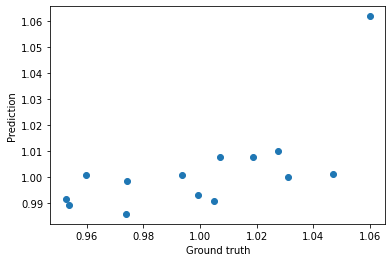

In [23]:
a, x, nets = next(iter(my_interface.test))

# Perform prediction
x_norm = my_normalizer(x)
y_hat = my_fully_connected.batch_forward(my_fully_connected.weights, x_norm)
y_post = my_postprocessor(y_hat)
y_post = np.reshape(y_post['bus']['res_vm_pu'], [-1])

# Get ground truth
my_interface.run_load_flow_batch(nets)
y_truth = my_interface.get_features_dict(nets, {'bus':['res_vm_pu']})
y_truth = np.reshape(y_truth['bus']['res_vm_pu'], [-1])

# Compare results
plt.scatter(y_truth, y_post)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

# Defining a Hyper Heterogeneous Multi Graph Neural Ordinary Differential Equation (H2MGNODE)

The H2MGNODE combines the Hyper Heterogeneous Multi Graph Neural Network and Neural Ordinary Differential Equations.

It uses an architecture very similar to the H2MGNN architecture, but it solves the latent system of equations using a variable timestep method. Contrarily to the fully connected, you do not have to specify the amount of objects of each class at the initialization. It will take as input both the addresses $a$ and the features $x$. One should tell the H2MGNODE which addresses it should be using to propagate information.

In [47]:
addresses = {}
addresses['bus']       = ['id']
addresses['gen']       = ['bus']
addresses['load']      = ['bus']
addresses['shunt']     = ['bus']
addresses['ext_grid']  = ['bus']
addresses['line']      = ['from_bus', 'to_bus']
addresses['trafo']     = ['hv_bus', 'lv_bus']
addresses['poly_cost'] = ['element']

input_features = {}
input_features['bus']       = ['in_service', 'max_vm_pu', 'min_vm_pu', 'vn_kv']
input_features['load']      = ['const_i_percent', 'const_z_percent', 'controllable', 'in_service', 
                               'p_mw', 'q_mvar', 'scaling', 'sn_mva']
input_features['gen']       = ['in_service', 'p_mw', 'scaling', 'sn_mva', 'vm_pu', 'slack', 'max_p_mw', 
                               'min_p_mw', 'max_q_mvar', 'min_q_mvar', 'slack_weight']
input_features['shunt']     = ['q_mvar', 'p_mw', 'vn_kv', 'step', 'max_step', 'in_service']
input_features['ext_grid']  = ['in_service', 'va_degree', 'vm_pu', 'max_p_mw', 'min_p_mw', 'max_q_mvar',
                               'min_q_mvar', 'slack_weight']
input_features['line']      = ['c_nf_per_km', 'df', 'g_us_per_km', 'in_service', 'length_km', 'max_i_ka',
                               'max_loading_percent', 'parallel', 'r_ohm_per_km', 'x_ohm_per_km']
input_features['trafo']     = ['df', 'i0_percent', 'in_service', 'max_loading_percent', 'parallel', 
                               'pfe_kw', 'shift_degree', 'sn_mva', 'tap_max', 'tap_neutral', 'tap_min', 
                               'tap_phase_shifter', 'tap_pos', 'tap_side', 'tap_step_degree', 
                               'tap_step_percent', 'vn_hv_kv', 'vn_lv_kv', 'vk_percent', 'vkr_percent']
input_features['poly_cost'] = ['cp0_eur', 'cp1_eur_per_mw', 'cp2_eur_per_mw2', 'cq0_eur', 
                               'cq1_eur_per_mvar', 'cq2_eur_per_mvar2']

output_features = {}
output_features['bus'] = ['res_vm_pu']

In [48]:
my_h2mgnode = H2MGNODE(addresses=addresses, 
                       input_features=input_features, 
                       output_features=output_features, 
                       hidden_dimensions=[64], 
                       latent_dimension=32)
my_h2mgnode.save('my_h2mgnode.pkl')

In [49]:
class PostProcessor:
    def __call__(self, y):
        return {'bus': {'res_vm_pu': self.bus_v_mag(y['bus']['res_vm_pu'])}}
    def bus_v_mag(self, y):
        return 1.+y
my_postprocessor = PostProcessor()

In [50]:
def loss(params, init_state, y_truth):
    y_hat = my_h2mgnode.solve_and_decode_batch(params, init_state)
    y_post = my_postprocessor(y_hat)
    return jnp.mean((y_truth['bus']['res_vm_pu'] - y_post['bus']['res_vm_pu'])**2)

@jit
def update(params, init_state, y_truth, opt_state):
    value, grads = value_and_grad(loss)(params, init_state, y_truth)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [51]:
step_size = 3e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(my_h2mgnode.weights)

In [52]:
for epoch in range(50):
    
    # Training loop
    train_pbar = tqdm(my_interface.train)
    train_losses = []
    for a, x, nets in train_pbar:
        
        my_interface.run_load_flow_batch(nets)
        y_truth = my_interface.get_features_dict(nets, {'bus':['res_vm_pu']})
        
        x_norm = my_normalizer(x)
        init_state = my_h2mgnode.init_state_batch(a, x_norm)
        my_h2mgnode.weights, opt_state, train_loss = update(my_h2mgnode.weights, init_state, y_truth, opt_state)

        train_losses.append(train_loss)
        train_pbar.set_description("Epoch {}, Train loss = {:.2e}".format(epoch, train_loss))
    
    # Compute metrics over validation set
    val_pbar = tqdm(my_interface.val)
    val_losses = []
    for a, x, nets in val_pbar:
        my_interface.run_load_flow_batch(nets)
        y_truth = my_interface.get_features_dict(nets, {'bus':['res_vm_pu']})
    
        x_norm = my_normalizer(x)
        init_state = my_h2mgnode.init_state_batch(a, x_norm)
        val_loss = loss(my_h2mgnode.weights, init_state, y_truth)
        val_losses.append(val_loss)
        
    print("Epoch {}".format(epoch))
    print("    Train mean loss = {:.2e}".format(np.mean(train_losses)))
    print("    Validation mean loss = {:.2e}".format(np.mean(val_losses)))

Epoch 0, Train loss = 2.77e-04:   3%|███                                                                                               | 222/6983 [03:15<1:39:17,  1.13it/s]


KeyboardInterrupt: 

# Compute metrics

In [104]:
losses = []
maes = []

pbar = tqdm(my_interface.test)
for a, x, nets in pbar:
    
    # Perform prediction
    x_norm = my_normalizer(x)
    y_hat = my_h2mgnode.batch_forward(my_h2mgnode.weights, a, x_norm)
    y_post = my_postprocessor(y_hat)

    # Get ground truth
    my_interface.compute_load_flow(nets)
    y_truth = my_interface.get_features(nets, {'bus':['v_mag']})
    
    # Compute metrics
    loss = (y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])**2
    mae = np.abs(y_post['bus']['v_mag'] - y_truth['bus']['v_mag'])
    losses.extend(list(loss))
    maes.extend(list(mae))
    
print('Loss')
print('    max        = {:e}'.format(np.max(losses)))
print('    90th perc. = {:e}'.format(np.percentile(losses, 90)))
print('    50th perc. = {:e}'.format(np.percentile(losses, 50)))
print('    10th perc. = {:e}'.format(np.percentile(losses, 10)))
print('    min        = {:e}'.format(np.min(losses)))
print('')
print('MAE')
print('    max        = {:e}'.format(np.max(maes)))
print('    90th perc. = {:e}'.format(np.percentile(maes, 90)))
print('    50th perc. = {:e}'.format(np.percentile(maes, 50)))
print('    10th perc. = {:e}'.format(np.percentile(maes, 10)))
print('    min        = {:e}'.format(np.min(maes)))

  0%|                                                                                                                                              | 0/1000 [00:00<?, ?it/s]


AttributeError: 'H2MGNODE' object has no attribute 'batch_forward'

# Plot prediction against ground truth

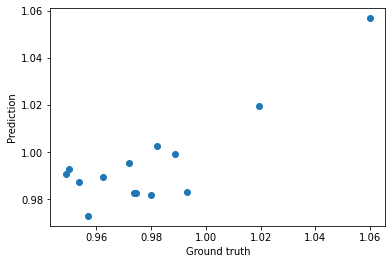

In [53]:
a, x, nets = next(iter(my_interface.test))
x_norm = my_normalizer(x)
y_hat = my_h2mgnode.forward_batch(my_h2mgnode.weights, a, x_norm)
y_post = my_postprocessor(y_hat)

# Get ground truth
my_interface.run_load_flow_batch(nets)
y_truth = my_interface.get_features_dict(nets, {'bus': ['res_vm_pu']})

# Compare results
plt.scatter(y_truth['bus']['res_vm_pu'], y_post['bus']['res_vm_pu'])
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

# Plot the evolution of latent variables

The H2MGNODE architecture is based on the interaction of latent variables defined at both hyper edges and addresses (namely $h_e$ and $h_v$). We propose 

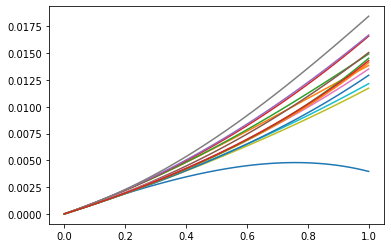

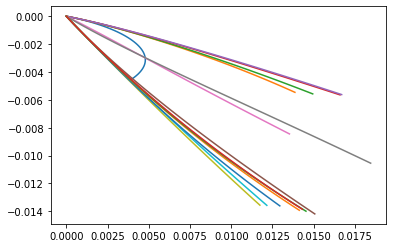

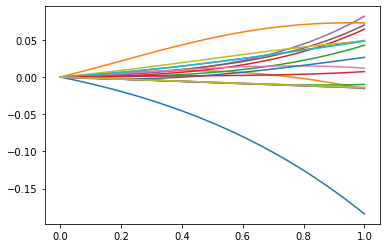

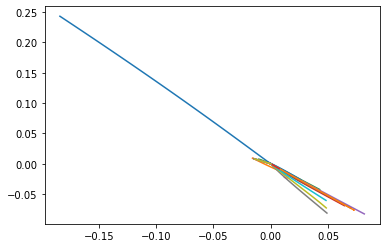

In [44]:
start_and_end_times = jnp.linspace(0., 1., 50)
def odenet(params, init_state):
    intermediate_states = odeint(my_h2mgnode.dynamics, init_state, start_and_end_times, params)
    return intermediate_states
batched_odenet = vmap(odenet, in_axes=(None, 0))
    
a, x, nets = next(iter(my_interface.test))
x_norm = my_normalizer(x)
init_state = my_h2mgnode.init_state_batch(a, x_norm)
intermediate_states = batched_odenet(my_h2mgnode.weights, init_state)

y_plot = intermediate_states['h_e']['bus'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_e']['bus'][0,:,:,0]
y_plot = intermediate_states['h_e']['bus'][0,:,:,2]
plt.plot(x_plot, y_plot)
plt.show()

y_plot = intermediate_states['h_v'][0,:,:,0]
plt.plot(start_and_end_times, y_plot)
plt.show()

x_plot = intermediate_states['h_v'][0,:,:,0]
y_plot = intermediate_states['h_v'][0,:,:,1]
plt.plot(x_plot, y_plot)
plt.show()